# Learner Part 2

<img src="learner2.jpg" alt="learner image" width="400"/>

In part 1, we looked at a basic learner and a callback learner. The basic learner's code was hand-written without any flexibility. We would have to modify the learner if we want to change a metric. With a callback learner, we could use callbacks to change a metric or some additional behaviors such as `before_fit`, `after_batch`, etc.

In part 2, we will look at a more flexible version of learner and some useful callbacks, such as `ProgressCB` and `LRFinderCB`. `ProgressCB` draws a graph with train and validation loss and `LRFinderCB` allows us to find a learning rate very fast. This blog is based on [lesson 16](https://course.fast.ai/Lessons/lesson16.html) of the FastAI course.

## Environment setup

Let's install and import libraries we need.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
!pip install -q datasets
!pip install -q torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.5 MB/s eta 0:00:00


In [3]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *
from miniai.learner import *

from fastprogress import progress_bar,master_bar

In [4]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close

In [5]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

logging.disable(logging.WARNING)

In [6]:
from datasets import Array2D

In [7]:
x,y = 'image','label'
name = "fashion_mnist"
builder = load_dataset_builder(name)
dsd_features = builder.info.features.copy()
dsd_features['image'] = Array2D(shape=[1, 28*28], dtype='float32')
dsd = load_dataset(name, features=dsd_features)
dsd.set_format(type="torch")

@inplace
def sq(b): b[x] = [o.squeeze().div(255) for o in b[x]]

tds = dsd.map(sq, batched=True)
bs = 1024
dls = DataLoaders.from_dd(tds, bs)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Progress Callback

`ProgressCB` uses [fastprogress](https://github.com/fastai/fastprogress) to generate a graph for losses. It is beneficial to visualize how our model trains throughout each batch. This callback uses `_log` to overwrite `learn.metrics._log`. So, instead of printing losses, it creates the graph.

It is interesting to understand what's going on in this code, but it is okay to skip.

In [8]:
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses:
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],
                                        [fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

    def after_epoch(self, learn):
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'):
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],
                                        [fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

## Flexible Learner

We will build a flexible learner with decorators. There are two ways of defining it: with a class and wtih a function. They are both 11 lines of code. However, the function version is a bit weird because it has a wrapper and decorator inside of `with_cbs`. So, the class version might be easier to read.

Here is a simple decorator built with a class. It saves a name and prints a greeting with the name each time the function is called. Then we have a `do_chores` function that tells the person to finish any chore. It is a very friendly way of getting the job done.

In [9]:
class Greeting_decorator:
    def __init__(self, name):
        self.name = name

    def __call__(self, f):
        print(f'Creating a decorator with f: {f}, name: {self.name}')
        def _f(*args, **kwargs):
            print(f'Hello, {self.name}')
            f(*args, **kwargs)
        return _f

In [10]:
@Greeting_decorator('Bobby')
def do_chores(chore): print(f'Please finish {chore}')

Creating a decorator with f: <function do_chores at 0x7bde4cea4e50>, name: Bobby


In [11]:
do_chores('the dishes')

Hello, Bobby
Please finish the dishes


In [12]:
class with_cbs:
    def __init__(self, name):
        self.name = name

    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.name}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.name}')
            except globals()[f'Cancel{self.name.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.name}')
        return _f

So, here is our final version of the learner. It is longer than before, but it is not hard to understand. `fit` can take additional parameters, such as `train`, `valid`, `cbs`, and `lr`. `train` and `valid` tells whether to use train data or not and to use valid data or not. `cbs` can optionally add callbacks for fitting and removes them after fitting. `lr` can be added for fitting like callbacks.

Additionally, there are callbacks for `one_batch`, such as `after_predict`, `after_loss`, `after_backward`, and `after_step`.

In [13]:
def get_model(): return nn.Sequential(nn.Linear(784, 100), nn.ReLU(), nn.Linear(100, 10))

In [14]:
from torcheval.metrics import MulticlassAccuracy,Mean

In [15]:
class Learner:
    def __init__(self, model, dls, loss_func=F.mse_loss, lr=0.1, opt_func=optim.SGD, cbs = None): fc.store_attr()

    def fit(self, n_epochs=1, train=True, valid=True, cbs=[], lr=None):
        try:
            for c in cbs: self.cbs.append(c)
            if lr is None: lr = self.lr
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), lr=lr)
            self._fit(train, valid)
        finally:
            for c in cbs: self.cbs.remove(c)

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.batch in self.dl: self._one_batch()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            with torch.no_grad():
                self.backward()
                self.callback('after_backward')
                self.step()
                self.callback('after_step')
                self.zero_grad()

    def callback(self, name): run_cbs(self.cbs, name, self)

    def __getattr__(self, o):
        if o in ['predict', 'get_loss', 'backward', 'step', 'zero_grad']:
            return partial(self.callback, o)
        raise AttributeError(o)

    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
0.623,1.160,0,train
0.702,0.839,0,eval


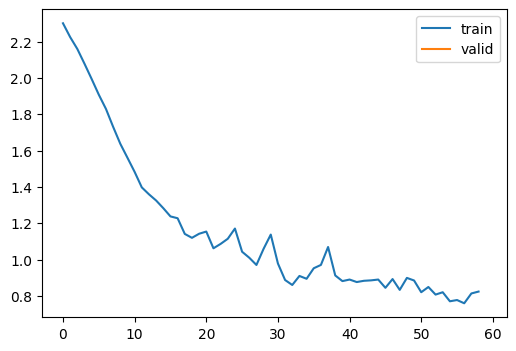

In [16]:
model = get_model()

metric = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [metric, ProgressCB(plot=True), TrainCB(), DeviceCB()]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

Yay, it trains and draws a graph as well! If you feel adventurous, you can rewrite this as much as possible without peeking. After that, you can get a good sense of how it works. Then, look back and check the answer. I was having a weird error because I was writing `self.model.training = training` instead of `self.model.train(training)`. My model did not change into validation mode and tried to do a backward step! Then, it gave me an error. I was able to fix the error by looking at Jeremy's code.

## TrainLearner and MomentumLearner

By inheriting our learner, we can create `TrainLearner` by defining the training process, such as `predict`, `get_loss`, `backward`, etc. This way, we don't have to type `learn.preds` because it belongs to `self`. And methods don't take `learn` either.

Also, by inheriting from `TrainLearner`, we can create `MomentumLearner`. Instead of setting gradients to zero on `zero_grad` step, we keep some of the gradients by multiplying them by momentum. This way, gradients move smoothly like water flowing down the drain, and it is faster to train.

In [17]:
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [18]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func=F.mse_loss, lr=0.1, opt_func=optim.SGD, cbs=None, mom=.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, opt_func, cbs)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p *= self.mom

accuracy,loss,epoch,train
0.663,0.963,0,train
0.800,0.553,0,eval


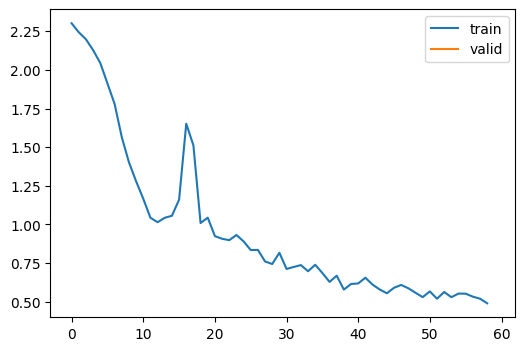

In [19]:
model = get_model()

metric = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [metric, ProgressCB(plot=True), TrainCB(), DeviceCB()]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

The accuracy is better than the pervious one.

Of course we can do the same thing with callbacks.

In [20]:
class MomentumCB(TrainCB):
    def __init__(self, n_inp=1, mom=.85):
        self.mom = mom
        super().__init__(n_inp)

    def zero_grad(self, learn):
        with torch.no_grad():
            for p in learn.model.parameters():
                p *= self.mom

accuracy,loss,epoch,train
0.665,0.979,0,train
0.800,0.555,0,eval


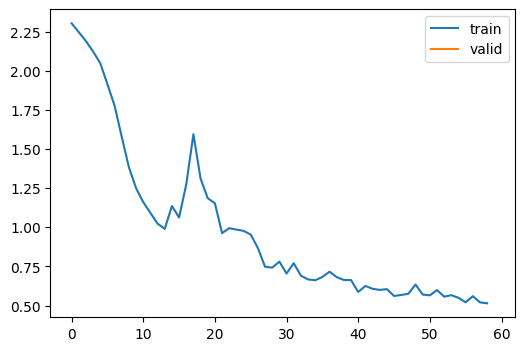

In [21]:
model = get_model()

metric = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [metric, ProgressCB(plot=True), MomentumCB(), DeviceCB()]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## LRFinderCB

It's time to look at `LRFinderCB`, which allows us to find the learning rate very quickly. It only uses the training part. In every batch, the callback increases the learning rate by a certain amount. It also keeps the minimum loss. This value gets updated if a smaller loss is found. If the current loss is bigger than three times the minimum loss, training stops. Then it plots the loss and learning rate.

In [34]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): self.lr_mult = lr_mult
    def before_fit(self, learn):
        self.losses, self.lrs = [], []
        self.min_loss = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        loss = learn.loss.detach().cpu()
        self.losses.append(loss)
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        if loss < self.min_loss: self.min_loss = loss
        if loss > 3 * self.min_loss: raise CancelFitException()
        for p in learn.opt.param_groups:
            p['lr'] *= self.lr_mult

In [38]:
model = get_model()

metric = MetricsCB(accuracy=MulticlassAccuracy())
lr_find = LRFinderCB()
cbs = [metric, ProgressCB(plot=True), MomentumCB(), DeviceCB(), lr_find]
learn = Learner(model, dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)

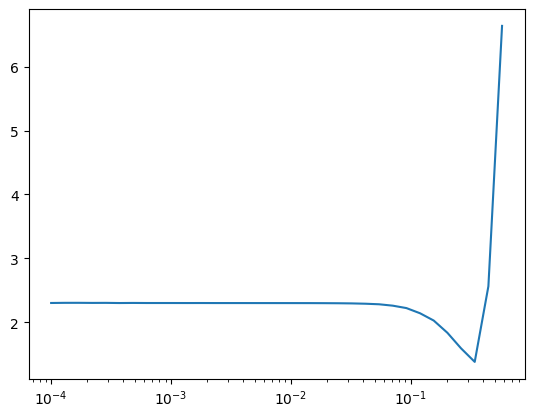

In [41]:
plt.plot(lr_find.lrs, lr_find.losses)
plt.xscale('log');

Okay, we got it. The ideal learning rate is a bit before it hits the absolute minimum loss, so we could use 0.1 or something smaller in this case. Why not choose the point when the loss is at the minimum?

Let's say we are playing mini golf. We are on the top of the ramp and the hole is at the bottom. The surface of the ramp has many little obstacles, which could change the course of the trajectory of the golf ball. The golf ball could get stuck on the obstacle if it went too slow and could pass the hole if it went too fast. So there has to be an ideal speed the golf ball has to tavel. By speeding up the speed of the golf ball each second from the top, we could figure out the speed we need. By this analogy, it was too fast when the ball hit the hole, so we want to use the speed before it hit the bottom.


## Conclusion

In this blog, we covered the final version of the learner which had flexibility and rigidity. Instead of changing the learner to modify how the model trains, we could add or remove callbacks. We could also inherit learner if we wanted to. We also looked at some interesting callbacks, such as `LRFinderCB` and `ProgressCB`.